# Đánh giá khớp (Hồi quy đa thức)

Trong notebook này, chúng ta sẽ so sánh các mô hình hồi quy khác nhau để đánh giá xem mô hình nào khớp nhất. Chúng ta sẽ sử dụng hồi quy đa thức để xem xét chủ đề này. Cụ thể, chúng ta sẽ:
* Viết hàm nhận một đặc trưng đơn lẻ (trong mảng Numpy/Series) và một bậc, trả về một DataFrame có từng cột là đặc trưng tới giá trị đa thức lên tới tổng bậc, chẳng hạn: bậc = 3 thì cột 1 là đặc trưng ban đầu, cột 2 là đặc trưng bình phương và cột 3 là đặc trưng lập phương.
* Sử dụng matplotlib để trực quan hóa hồi quy đa thức.
* Sử dụng matplotlib để trực quan hóa cùng bậc đa thức trong cùng một tập con dữ liệu.
* Sử dụng tập kiểm định để chọn bậc đa thức.
* Đánh giá khớp cuối cùng sử dụng dữ liệu kiểm tra.

Chúng ta vẫn sử dụng dữ liệu nhà ở từ notebook trước.

## Thư viện

In [ ]:
import sklearn
import pandas
import numpy as np

Tiếp theo, chúng ta sẽ viết hàm đa thức nhận một đặc trưng và một bậc cực đại, trả về DataFrame chứa tất cả các lũy thừa của đặc trưng cho đến bậc cực đại.

Cách đơn giản nhất để vận dụng lũy thừa vào một Series là sử dụng các hàm `.apply` và `lambda x:`. Tuy nhiên, mảng Numpy chỉ có thể thực hiện nó dễ dàng với các phép số học đơn giản; nếu không, nó sẽ yêu cầu `np.vectorize` khó hiểu hơn. Ví dụ để lấy mảng mock và tính lũy thừa bậc ba, chúng ta có thể làm như sau:

In [ ]:
mock = np.array([1., 2., 3.])
mock_series = pandas.Series(mock)
mock_cubed = mock ** 3
mock_cubed_long = np.vectorize(lambda x: x ** 3)(mock)
mock_series_cubed = mock_series.apply(lambda x: x ** 3)
print(mock, mock_cubed, mock_cubed_long)
print(mock_series, "\n", mock_series_cubed)

[1. 2. 3.] [ 1.  8. 27.] [ 1.  8. 27.]
0    1.0
1    2.0
2    3.0
dtype: float64 
 0     1.0
1     8.0
2    27.0
dtype: float64


Chúng ta có thể tạo một DataFrame trống sử dụng `pandas.DataFrame()`, sau đó thêm bất kỳ cột nào vào đó với `dataframe['column_name'] = value`. Chẳng hạn, chúng ta tạo một DataFrame trống và đặt cột 'power_1' là lũy thừa bậc một của giá trị mock.

In [ ]:
data = pandas.DataFrame()
data['power_1'] = mock
print(data)

   power_1
0      1.0
1      2.0
2      3.0


## Hàm `polynomial_dataframe`

Sử dụng các gợi ý phía trên để hoàn thiện hàm sau:

In [ ]:
def polynomial_dataframe(feature, degree):
    # giả sử bậc >= 1
    # khởi tạo DataFrame:
    poly_data = pandas.DataFrame()
    # và đặt poly_data['power_1'] bằng với đặc trưng đã truyền vào
    poly_data['power_1'] = feature
    # trước tiên kiểm tra xem bậc có lớn hơn 1 không
    if degree > 1:
        # thì lặp qua các bậc còn lại:
        # range thường bắt đầu range từ 0 và kết thúc ở đầu cuối -1. Chúng ta cần nó bắt đầu từ 2 và ngừng ở bậc
        for power in range(2, degree+1):
            # trước tiên đặt tên cột:
            name = 'power_' + str(power)
            # sau đó gán poly_sframe[name] cho lũy thừa thích hợp của đặc trưng
            poly_data[name] = feature**power
    return poly_data

Kiểm tra hàm với biến **mock** và kết quả dự kiến của cell sau:

In [ ]:
print(polynomial_dataframe(mock, 3))

   power_1  power_2  power_3
0      1.0      1.0      1.0
1      2.0      4.0      8.0
2      3.0      9.0     27.0


# Trực quan hóa hồi quy đa thức

Sử dụng matplotlib để hiển thị hồi quy đa thức trông như thế nào trong dữ liệu thực.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_data = pandas.read_csv("/content/drive/MyDrive/Colab_Notebooks/Bai tap lap/Mon_hoc_2/kc_house_data.csv", index_col=0)

Chúng ta sẽ dùng biến sqft_living. Để vẽ biểu đồ (nối các chấm), chúng ta cần sắp xếp giá trị của sqft_living. Những ngôi nhà có diện tích giống nhau sẽ phân biệt theo giá.

In [ ]:
full_data = full_data.sort_values(['sqft_living', 'price'])

Hãy bắt đầu với đa thức bậc 1 sử dụng 'sqft_living' (chẳng hạn 1 dòng) để dự đoán 'price' và vẽ biểu đồ xem nó trông như thế nào.

In [ ]:
poly1_data = polynomial_dataframe(full_data['sqft_living'], 1)
poly1_data['price'] = full_data['price'] # add price to the data since it's the target

In [ ]:
print(poly1_data.head(5))

            power_1     price
id                           
3980300371      290  142000.0
2856101479      370  276000.0
1723049033      380  245000.0
1222029077      384  265000.0
6896300380      390  228000.0


Đó là dữ liệu. Đã đến lúc tạo mô hình và thử với nó.

In [ ]:
from sklearn.linear_model import LinearRegression
features_poly1 = np.reshape(poly1_data['power_1'].values, [-1, 1])
labels_poly1 = poly1_data['price'].values
model1 = LinearRegression().fit(features_poly1, labels_poly1)

In [ ]:
#hãy xem các trọng số trước khi vẽ biểu đồ
model1.coef_

array([280.6235679])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

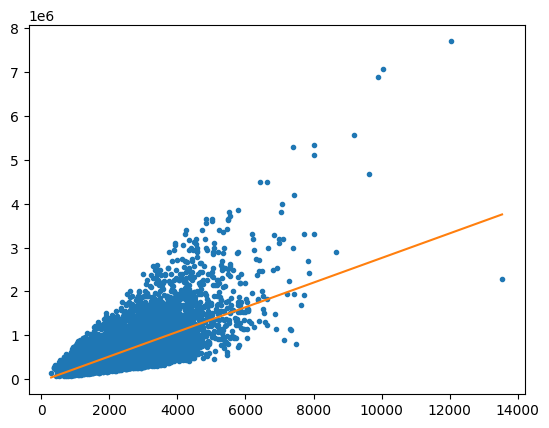

In [ ]:
plt.plot(poly1_data['power_1'],poly1_data['price'],'.',
        poly1_data['power_1'], model1.predict(features_poly1),'-')

Hãy giải nén lệnh plt.plot(). Cặp đầu tiên là lũy thừa bậc 1 của sqft và giá thực, sau đó yêu cầu in chúng thành các giá trị thứ ba ('.'). Cặp tiếp theo là lũy thừa bậc 1 của sqft và các giá trị dự đoán từ mô hình tuyến tính được vẽ thành một đường '-'.

Không có gì ngạc nhiên khi giá trị dự đoán đều nằm trên một đường, đặc biệt là đường với slope 280 và intercept -43579. Sẽ ra sao nếu chúng ta muốn vẽ một bậc đa thức thứ hai?

In [ ]:
poly2_data = polynomial_dataframe(full_data['sqft_living'], 2) # create polynomial up to 2 degree
features_poly2 = poly2_data.values # extract the features immediately
poly2_data['price'] = full_data['price']
labels_poly2 = poly2_data['price'].values # receive the labels

model2 = LinearRegression().fit(features_poly2, labels_poly2)

In [ ]:
model2.coef_

array([6.79940947e+01, 3.85812609e-02])

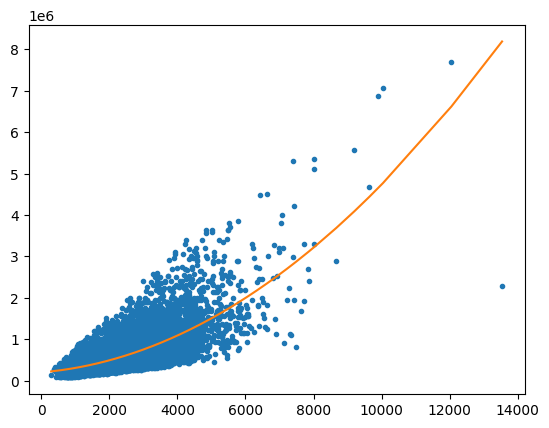

In [ ]:
plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(features_poly2),'-')

Mô hình kết quả có dạng một nửa parabol. Thử với mô hình với bậc 3 xem nó trông thế nào:

In [ ]:
# 1, 2, 3. Một lần nữa, Ctrl+C, Ctrl+V, chỉnh
poly3_data = polynomial_dataframe(full_data['sqft_living'], 3)
feature_poly3 = poly3_data.values
label_poly3 = full_data['price'].values
model3 = LinearRegression().fit(feature_poly3,label_poly3)
model3.coef_

array([-9.01819864e+01,  8.70465089e-02, -3.84055260e-06])

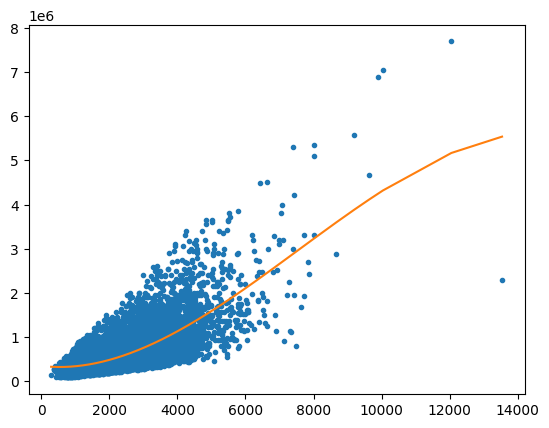

In [ ]:
# Hãy cẩn thận với thay thế của bạn
plt.plot(full_data['sqft_living'], full_data['price'], '.',
         full_data['sqft_living'], model3.predict(feature_poly3), '-')

Giờ hãy thử đa thức bậc 15:

In [ ]:
# Có rất nhiều cột
# 1, 2, 3. Một lần nữa, Ctrl+C, Ctrl+V, chỉnh
poly15_data = polynomial_dataframe(full_data['sqft_living'], 15)
feature_poly15 = poly15_data.values
label_poly15 = full_data['price'].values
model15 = LinearRegression().fit(feature_poly15,label_poly15)
model15.coef_

array([ 1.71282676e-05,  4.21884655e-02,  4.60063742e-06, -4.52411680e-10,
       -2.28567165e-14, -2.18575158e-16, -5.21284405e-16,  3.53016227e-16,
       -2.01227923e-16, -2.79290480e-16,  1.08637058e-16,  7.31619626e-16,
        4.33680869e-16, -4.00721123e-16,  5.55111512e-17])

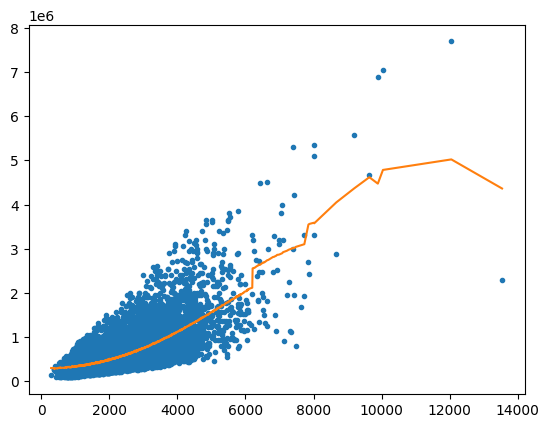

In [ ]:
# Ctrl+H có thể không ổn nếu bạn không copy từ cell tốt hơn
# Hãy cẩn thận với thay thế của bạn
plt.plot(full_data['sqft_living'], full_data['price'], '.',
         full_data['sqft_living'], model15.predict(feature_poly15), '-')

Đa thức bậc 15 như thế nào? Nó có thích hợp không? Nếu chúng ta thay đổi dữ liệu thì có được đường cong cũng tương tự không? Hãy xem kết quả.

## Thay đổi dữ liệu và học lại

Chúng ta sẽ chia dữ liệu bán hàng thành 4 tập con có kích thước tương tự nhau. Sau đó ước tính một mô hình đa thức bậc 15 cho cả 4 tập con dữ liệu. In ra các hệ số (nên dùng `.coef_` để truy cập các tham số của mô hình) và vẽ biểu đồ kết quả khớp (đã thực hiện phía trên). Quiz sẽ hỏi về các kết quả này.

Để chia dữ liệu bán hàng thành 4 tập con, chúng ta thực hiện như sau:
* Đầu tiên, chia full_data thành 2 tập con với `train_test_split(full_data, train_size=0.5, test_size=0.5 seed=0)`.
* Tiếp theo chia mỗi tập con kết quả thành 2 tập con nữa với `train_test_split(big_set_?, train_size=0.5, test_size=0.5, random_state=0)`.

Chúng ta thiết lập `seed=0` trong các bước này để những người dùng khác nhau sẽ được các kết quả thống nhất.
Chúng ta nên kết thúc với 4 tập con (`set_1`, `set_2`, `set_3`, `set_4`) có kích thước xấp xỉ nhau.

In [ ]:
from sklearn.model_selection import train_test_split
big_set_1, big_set_2 = train_test_split(full_data, train_size=0.5, test_size=0.5, random_state=0)
set_1, set_2 = train_test_split(big_set_1, train_size=0.5, test_size=0.5, random_state=0)
set_3, set_4 = train_test_split(big_set_2, train_size=0.5, test_size=0.5, random_state=0)

**test_size=0.5 có cần thiết không?**

Khớp đa thức bậc 15 vào set_1, set_2, set_3, và set_4 sử dụng sqft_living để đoán giá. Vẽ biểu đồ mô hình kết quả (in các hệ số cho 'power_1' nếu muốn).

In [ ]:
# Bạn có thể vẽ mô hình ở đây

In [ ]:
# Sau đó copy cho cả 4

In [ ]:
# Hoặc thực hiện tất cả một lúc

In [ ]:
# nếu biết lặp, subplot và axes

In [ ]:
poly15_set_1 = polynomial_dataframe(set_1['sqft_living'], 15)
feature_poly15_set1 = poly15_set_1.values
label_poly15_set1 = set_1['price'].values
model15_set1 = LinearRegression().fit(feature_poly15_set1,label_poly15_set1)
print(model15_set1.coef_)

poly15_set_2 = polynomial_dataframe(set_2['sqft_living'], 15)
feature_poly15_set2 = poly15_set_2.values
label_poly15_set2 = set_2['price'].values
model15_set2 = LinearRegression().fit(feature_poly15_set2,label_poly15_set2)
print(model15_set2.coef_)

poly15_set_3 = polynomial_dataframe(set_3['sqft_living'], 15)
feature_poly15_set3 = poly15_set_3.values
label_poly15_set3 = set_3['price'].values
model15_set3 = LinearRegression().fit(feature_poly15_set3,label_poly15_set3)
print(model15_set3.coef_)

poly15_set_4 = polynomial_dataframe(set_4['sqft_living'], 15)
feature_poly15_set4 = poly15_set_4.values
label_poly15_set4 = set_4['price'].values
model15_set4 = LinearRegression().fit(feature_poly15_set4,label_poly15_set4)
print(model15_set4.coef_)

[ 1.55659147e-05  3.31067037e-02  9.02618007e-06 -8.90793830e-10
 -2.10925027e-14 -2.08166817e-17 -1.00939222e-15  1.04777298e-15
  8.38088279e-17 -1.02001740e-15  1.84314369e-16 -5.88288099e-16
  1.28369537e-16 -4.29560901e-16  8.74300632e-16]
[ 2.68926806e-05  5.29187559e-02  3.32357492e-07 -1.44780798e-10
 -8.96158148e-15  1.87350135e-16 -4.89192020e-16  1.07552856e-16
 -2.95770353e-16  4.54497551e-16 -6.68302219e-16  7.56773116e-16
  6.52256027e-16  2.30718222e-16 -3.22658567e-16]
[ 1.64214725e-05  4.07228204e-02  5.91962275e-06 -5.57814421e-10
 -5.47201173e-14 -6.52256027e-16 -1.56125113e-17  9.32413868e-17
 -6.88685220e-16  3.14852311e-16  5.49039980e-16  1.74166237e-15
  2.46330734e-16 -6.48786580e-16 -7.80625564e-16]
[ 3.43410735e-05  7.53529733e-02 -9.56663613e-06  8.27255933e-10
  1.70974346e-14 -1.17961196e-16 -3.05311332e-16  1.38777878e-16
  1.66967135e-16 -9.12464548e-16  6.53990750e-16  9.78384040e-16
  1.16573418e-15 -6.93889390e-16  4.85722573e-16]


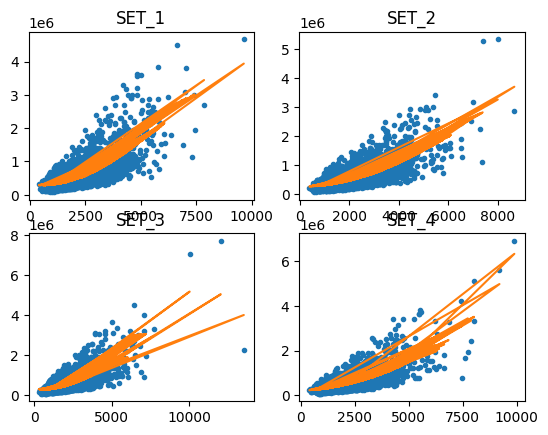

In [ ]:
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(set_1['sqft_living'], set_1['price'],'.',set_1['sqft_living'], model15_set1.predict(feature_poly15_set1))
axis[0, 0].set_title("SET_1")

# For Cosine Function
axis[0, 1].plot(set_2['sqft_living'], set_2['price'],'.',set_2['sqft_living'], model15_set2.predict(feature_poly15_set2))
axis[0, 1].set_title("SET_2")

# For Tangent Function
axis[1, 0].plot(set_3['sqft_living'], set_3['price'],'.',set_3['sqft_living'], model15_set3.predict(feature_poly15_set3))
axis[1, 0].set_title("SET_3")

# For Tanh Function
axis[1, 1].plot(set_4['sqft_living'], set_4['price'],'.',set_4['sqft_living'], model15_set4.predict(feature_poly15_set4))
axis[1, 1].set_title("SET_4")

# Combine all the operations and display
plt.show()


**Quiz: Dấu (dương hoặc âm) của power_15 có tương tự ở cả 4 mô hình không??** --> không

**Quiz: (Đúng/Sai) Đồ thị khớp đã vẽ trông tương tự nhau ở cả 4 mô hình.** --> 1 2 giống, 3 4 giống nhau

# Chọn bậc đa thức

Khi có tham số như bậc của đa thức, có một cách để lựa chọn các tham số này, đó là tập kiểm định. (Chúng ta sẽ khám phá một phương pháp khác sau).

Chúng ta chia tập dữ liệu bán hàng thành tập huấn luyện, tập kiểm tra và tập kiểm đinh như sau:

* Chia dữ liệu bán hàng thành 2 tập: `train_and_validation` và `test_data`. Sử dụng `train_test_split`.
* Tiếp tục chia tập huấn luyện thành 2 tập: `train_data` và `validation_data`. Sử dụng `train_test_split`.

Lần này, chúng ta sẽ thiết lập `random_state=1` để những người dùng có khác nhau có kết quả thống nhất.

In [ ]:
# Không cần import, trừ khi không chạy split phía trên
train_and_validation, test_data = train_test_split(full_data, train_size = 0.9, test_size = 0.1, random_state =1)
train_data, validation_data = train_test_split(train_and_validation, train_size = 0.89, test_size = 0.11, random_state =1)

Tiếp theo, chúng ta sẽ viết một vòng lặp như sau:
* Với bậc [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] (để nhận trong python, sử dụng `range(1, 15+1)` tích hợp sẵn)
    * Xây DataFrame của dữ liệu đa thức có train_data['sqft_living'] ở bậc hiện tại <br>
    *Gợi ý:* DataFrame giữ cho `.values` thống nhất với thứ tự cột
    * Load các nhãn của train_data
    * Tìm hiểu mô hình hồi quy đa thức 'sqft' -> 'price' với bậc đó trong dữ liệu HUẤN LUYỆN
    * Tính RSS trong dữ liệu KIỂM ĐỊNH (ở đây sẽ sử dụng `.predict()`) cho các bậc đó. Chúng ta sẽ cần áp dụng tất cả các bước trên vào tập kiểm định.
* Báo lại bậc nào có RSS thấp nhất trong dữ liệu kiểm định (chỉ mục python từ 0).

In [ ]:
from numpy.core.fromnumeric import argmin
# Đọc hướng dẫn và tiến hành. Chúng ta có thể loại một số giá trị ra khỏi vòng lặp
#=========Lưu model
model = []
#========Lưu RSS
RSS = []
RSS_train = []
#========label tập train
data_out = train_data['price']
data_out_label = data_out.values
#=========label tập val
data_val_out = validation_data['price']
data_val_out_label = data_val_out.values
for i in list(range(1,16)):
    #===========numpy các dữ liệu train
    data_in = polynomial_dataframe(train_data['sqft_living'], i)
    data_in_feature = data_in.values

    model_create = LinearRegression().fit(data_in_feature,data_out_label)
    #================Lưu model
    model.append(model_create)
    #==========numpy các dữ liệu val
    data_val_in = polynomial_dataframe(validation_data['sqft_living'], i)
    data_val_in_feature = data_val_in.values

    #================Tính RSS trên validation
    predicted_value = model_create.predict(data_val_in_feature)
    error = predicted_value - data_val_out_label
    residu_error = error@(error.T)
    RSS.append(residu_error)

    #=============Tính RSS trên train
    predicted_train = model_create.predict(data_in_feature)
    error_train = predicted_train - data_out_label
    residu_train = error_train@(error_train.T)
    RSS_train.append(residu_train)

print(argmin(RSS) + 1)

15


In [ ]:
print(RSS)

[162698728911407.34, 136351237124854.89, 137022894968677.95, 133951972057041.14, 133248272432919.45, 133257857445318.75, 133249393959944.2, 133204897024202.9, 133185969821193.1, 133188904874790.14, 133216397618437.12, 133172379697173.72, 133184238357158.75, 133175530179506.67, 133171795715487.08]


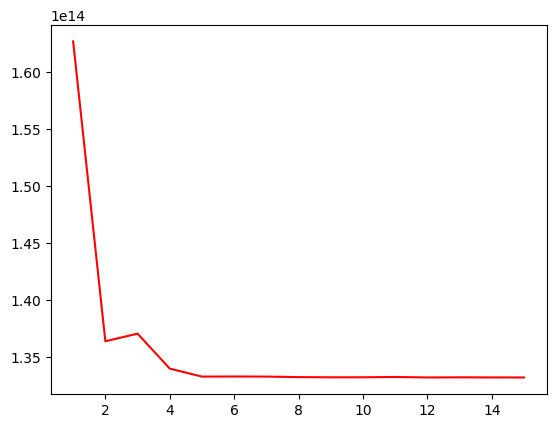

In [ ]:
plt.plot(range(1,16), RSS, 'r-')

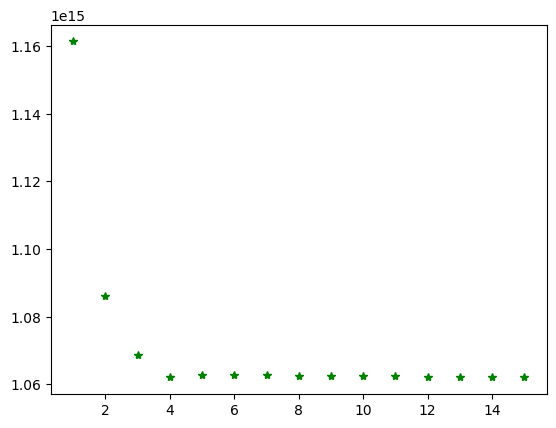

In [ ]:
plt.plot(range(1,16), RSS_train, 'g*')

**Quiz: Bậc nào (1, 2, …, 15) có RSS thấp nhất trong dữ liệu KIỂM ĐỊNH?**

Chúng ta đã chọn bậc của đa thức sử dụng dữ liệu kiểm định, hãy tính RSS của mô hình này trong dữ liệu KIỂM TRA. Báo cáo RSS trong quiz.

In [ ]:
# Mức độ trợ giúp: thấp
#==========numpy data_test
data_test_in = polynomial_dataframe(test_data['sqft_living'], 15)
data_test_in_feature = data_test_in.values
data_test_out = test_data['price']
data_test_out_label = data_test_out.values

data_test_predicted = model[14].predict(data_test_in_feature)
error_test = data_test_predicted - data_test_out_label
RSS_error = error_test@(error_test.T)

**Quiz: RSS trong dữ liệu KIỂM TRA cho mô hình với bậc được chọn từ dữ liệu KIỂM ĐỊNH là?**

In [ ]:
print(RSS_error/RSS[14])

1.0445323311934716
